# Oxygen Model Training

In [1]:
%cd ..

/home/rehak/repos/ops/ecris.analysis


## Training Data

Get a selection of CSD files that have not been used for training.

In [3]:
from pathlib import Path
from ops.ecris.analysis.io import read_csd_from_file_pair

CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILES_START: int = 480
N_FILES: int = 100
csds = [read_csd_from_file_pair(file) for file in CSD_FILEPATHS[FILES_START:FILES_START + N_FILES]]
print(f'Loaded {len(csds)} of {len(CSD_FILEPATHS)} CSD files.')

Loaded 100 of 1335 CSD files.


Define functions that will find all the peaks, and then use the `find_element_peaks` to identify likely oxygen peaks. If the peaks look like they line up, accept the peaks, otherwise reject them. This is a manual process.

In [ ]:
from ops.ecris.analysis.csd.m_over_q import estimate_m_over_q
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import random
from IPython.display import clear_output

from ops.ecris.analysis.model.csd import CSD
from ops.ecris.analysis.model.element import Element
from ops.ecris.analysis.csd.peaks import find_element_peaks
from ops.ecris.analysis.csd.ml import sorted_permutations

def get_training_peaks(csd: CSD):
    clear_output(wait=True)
    csd.m_over_q = estimate_m_over_q(csd)
    oxygen = Element('Oxygen', 'O', 16, 8)
    o2_peaks = find_element_peaks(csd, oxygen, 0.2)
    all_peaks, properties = find_peaks(csd.beam_current, prominence=0.1)
    sorted_peaks = np.flip(np.argsort(properties['prominences']))
    plt.plot(csd.m_over_q, csd.beam_current, '--')
    plt.plot(csd.m_over_q[o2_peaks.indexes], o2_peaks.beam_current, '+')
    for i in range(1, 9):
        plt.axvline(16/i, ls='--', alpha=0.25, c='k')
    plt.grid()
    plt.show()
    accept = input("Accept peaks? (Y/n)")
    if accept == 'n':
        return []

    for highest in [10, 15]:
        highest_peaks = sorted(all_peaks[sorted_peaks][:highest])
        permutations = sorted_permutations([int(v) for v in highest_peaks])
        total_sets = len(permutations)
        for i, p in enumerate(permutations):
            if p == o2_peaks.indexes:
                correct_peaks = permutations.pop(i)
                break
        if len(permutations) != total_sets - 1:
            print(f'Failed to fit with {highest=} with {len(permutations)=}')
            continue
        if len(permutations) > 1:
            bad_peaks = [permutations[i] for i in [random.randint(0, len(permutations) - 1) for _ in range(49)]]
        elif len(permutations) == 1:
            bad_peaks = permutations[0]
        else:
            bad_peaks = []
        training_peaks = [correct_peaks] + bad_peaks
        return training_peaks
    return []

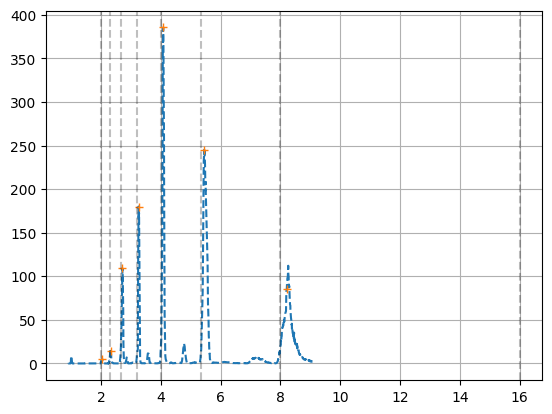

failed=38/100


In [24]:
x = []
y = []
failed = 0
for csd in csds:
    training_peaks = get_training_peaks(csd)
    if not training_peaks:
        failed += 1
        continue
    x.extend(training_peaks)
    y.extend([1] + (len(training_peaks) - 1)*[0])
print(f'{failed=}/{len(csds)}')

### Update training data

In [4]:
model_path = Path('./models/oxygen_nn/')

In [ ]:
new_x = np.array(x)
new_y = np.array(y)
print(new_x.shape, new_y.shape)
x_training = np.load(model_path / 'x_training.npy')
y_training = np.load(model_path / 'y_training.npy')
print(x_training.shape, y_training.shape)
x_output = np.concatenate([x_training, new_x])
y_output = np.concatenate([y_training, new_y])
print(x_output.shape, y_output.shape)

(3100, 7) (3100,)
(12000, 7) (12000,)
(15100, 7) (15100,)


Save new training data, backup the old data.

In [41]:
np.save(model_path / 'x_training.bak', x_training)
np.save(model_path / 'y_training.bak', y_training)
np.save(model_path / 'x_training', x_output)
np.save(model_path / 'y_training', y_output)

## Retrain the model

In [8]:
from ops.ecris.analysis.csd.ml import train_oxygen_model

parameters = model_path / 'mlp_csd_oxygen_params.json'
x_path = model_path / 'x_training.npy'
y_path = model_path / 'y_training.npy'
pipeline = train_oxygen_model(parameters, x_path, y_path)
pipeline

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"[30, 15, ...]"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


### Use the model

In [12]:
from scipy.signal import find_peaks

def estimate_correct_peaks(csd):
    all_peaks, properties = find_peaks(csd.beam_current, prominence=0.1, height=(10, None))
    sorted_peaks = np.flip(np.argsort(properties['prominences']))
    highest_peaks = sorted(all_peaks[sorted_peaks][:10])
    sorted_peaks = sorted_permutations([int(v) for v in highest_peaks])
    return sorted_peaks, pipeline.predict_proba(sorted_peaks)[:, 1]

In [13]:
import random

CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILE_NUM = random.randint(0, len(CSD_FILEPATHS))
csd = read_csd_from_file_pair(CSD_FILEPATHS[FILE_NUM])
estimated_peaks, probabilities = estimate_correct_peaks(csd)
highest_prob = np.flip(np.argsort(probabilities))[0]
csd.m_over_q = estimate_m_over_q(csd)

plt.plot(csd.m_over_q, csd.beam_current, '--')

highest_peaks = estimated_peaks[highest_prob]
plt.plot(csd.m_over_q[highest_peaks], csd.beam_current[highest_peaks], '+')
for i in range(1, 9):
    plt.axvline(16/i, ls='--', alpha=0.25, c='k')
plt.xlabel('M/Q (Estimated)')
plt.ylabel(r'Beam current ($\mu$A)')
plt.xlim([0,10])
plt.grid()
plt.show()
print(f'Estimated probability of O2 detection: {probabilities[highest_prob]}')

NameError: name 'np' is not defined

## Save model